# Mining in Wallapop 2024 Edition

This blog post was inspired by the post https://salvacarrion.github.io/data/analysis/2018/05/17/mining-in-wallapop.html. I decided to update and recreate the work of another Data Scientist.

Wallapop is an online marketplace to buy and sell stuff.
The purpose of this example is to remake Salva Carrion's work and to learn a bit more about online shopping patterns. During the process I'm going to walk you over how I found this idea, discovered the endpoints and built my own scrapper and how I integrated Cloud services to help me during the process. I will also show some visualizations and statistics about my findings.
Disclaimer, since there is a lot of data in there and a lot of possible analysis to be made, I'm going to make a super simple generalistic approach and not deep dive into any topic.

**Keywords**: Wallpop, Rest API, AWS, EDA

## Data Collection

The data was colleted through their rest API following. The process will be explained later, I'll start with a brief overview diagram of the dataflow.

```{mermaid}
graph TD
    A[Search Params] -->|get items_data| B[Items Data]
    B -->|order by distance latitude, long| B
    B -->|for objects get user_ids| C[user_ids]
    C -->|get user_profiles| D[Profiles Data]
    D -->|for user_id get reviews| E[Reviews]
    E -->|get sold_items from reviews| B2[Sold Items]
    B -->|store items| DB[(Database)]
    B2 -->|store sold_items| DB
    E -->|store reviews| DB

```

### Building the API

I used Firefox developer edition developer tools and manually inspected each server request, however there are more convinient ways to capture requests and responses (Burp Suit, i assume Postman as well).

My approach was to use ChatGPT to build a province list with latitude and longitude parameters and build a URL from there. My example:


```python
"{base_api_url}?latitude={coords['latitude']}&longitude={coords['longitude']}&filters_source=quick_filters&order_by=closest"
```

The response...

```json
{"search_objects":["{content}"],"from":0,"to":0,"distance_ordered":true,"keywords":null,"order":"closest","search_point":{"latitude":3.054268,"longitude":-39.476181}}
```

### Requests Crawler

The approach in the original post was to build a crawler using Scrapy. I did not use scrapy, I used raw requests because the data returned isn't always the same nor has the same format, and this would create very weird errors when using Scrapy built in Item dataclasses to parse indiviudal information. My approach would download all the raw json response data and deal with data structuring afterwards.


However, I did follow the same approach:

To get sold items, we should:

- Get items from page 0 to n for each Spain province
- Get all the sellers from the previous scrape
- Get all sold items from the previously scrapped sellers.


This is a great way to get blocked by the server, unless you are going to use proxies. My approach was to avoid unnecessary requests, so instead I sampled part of the sold items list and kept using a sequential approach.


### Data description


    Items: 758,227
    Reviews: 642,121
    Sellers: 161,519
    Item categories: 22
    Data size: ~10GB raw ~ 1.7GB compressed
    Others: Lots of outliers


![View on Eraser!](../assets/arch_overview.png)


### Unnormalized Data Structure

![ERD!](../assets/ERD.png)



In [55]:
import pandas as pd
import matplotlib.pyplot as plt

prices = pd.read_csv("data/prices.csv")
prices = prices.astype("float")

In [56]:
grouped = prices.groupby('category_id')['price_double'].describe()
grouped

,count,mean,std,min,25%,50%,75%,max
category_id,,,,,,,,
100.0,21711.0,23394.633354,1.357313e+06,0.0,5900.000,12900.00,19000.00,2.000000e+08
200.0,13257.0,153070.708893,2.738975e+05,0.0,1300.000,115000.00,239000.00,2.500000e+07
12461.0,65317.0,28.507046,5.911768e+02,0.0,5.000,10.00,21.00,1.500000e+05
12463.0,81480.0,29.698454,1.695190e+02,0.0,5.000,8.00,15.00,1.700000e+04
12465.0,197020.0,41.419987,1.437975e+03,0.0,6.000,12.50,30.00,6.009001e+05
12467.0,102551.0,105.969149,1.267283e+03,0.0,10.000,29.00,90.00,2.250000e+05
12485.0,23548.0,26004.244693,3.933186e+06,0.0,8.000,20.00,65.00,6.035611e+08
12545.0,14.0,17.642857,4.908503e+00,5.0,15.000,20.00,20.00,2.300000e+01
12579.0,29686.0,155.328083,5.928775e+03,0.0,11.025,29.00,75.00,9.999990e+05


Now we see some interesting things:

- Min values and Max values are absolute nonsense
- mean values are way too far from the median (skewed distribution)
- standard deviations are also way larger than they should.
- All distributions are heavily long-tailed.

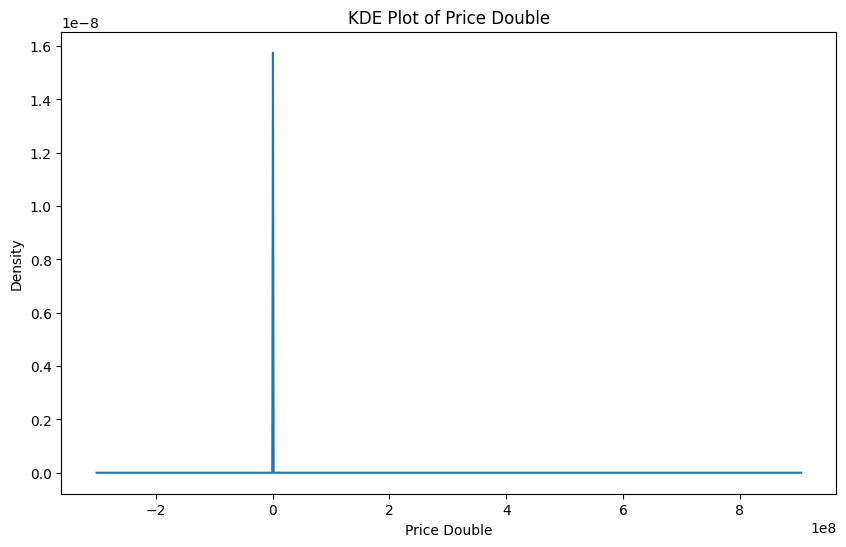

In [57]:
prices['price_double'].plot.kde(figsize=(10, 6))
plt.title('KDE Plot of Price Double')
plt.xlabel('Price Double')
plt.ylabel('Density')
plt.show()

From the above image, we see nothing. However, we can guess that Z-Score is not going to be a good method to remove outliers as they’re pulling up the standard deviation.

### Data Cleaning

We shouldn’t assume that data our follow a normal distribution, at least not yet. First, we can try to remove some clearly strong outliers using a couple methods:

    IQR: Good choice, but tuning
    Percentiles: too subjective without strong evidence to support our choices.
    Z-Score: is not robust enough due to the large standard deviations.
    Z-Score modified: better than above, but still not good enough*.
    Covariance estimators: similar to the above and requires a careful parameter tuning.
    One class SVM with a non-linear kernel (RBF): too slow.


I'm going to use Percentiles cutt offs since it's the best cost effective method. Addional methods would require a more time consuming and computationally consuming approach.

Cutt-offs: 5%-90% Q, assuming data is fat tailed (positive skewed)

In [58]:
# Calculate 5% and 90% quantiles for each category_id
quantiles = prices.groupby('category_id')['price_double'].quantile([0.05, 0.90]).unstack()

# Filter prices within the 5% and 90% quantile range for each category_id
def filter_quantiles(df):
    category_id = df.name
    lower_quantile = quantiles.loc[category_id, 0.05]
    upper_quantile = quantiles.loc[category_id, 0.90]
    return df[(df['price_double'] >= lower_quantile) & (df['price_double'] <= upper_quantile)]

filtered_prices = prices.groupby('category_id').apply(filter_quantiles).reset_index(drop=True)


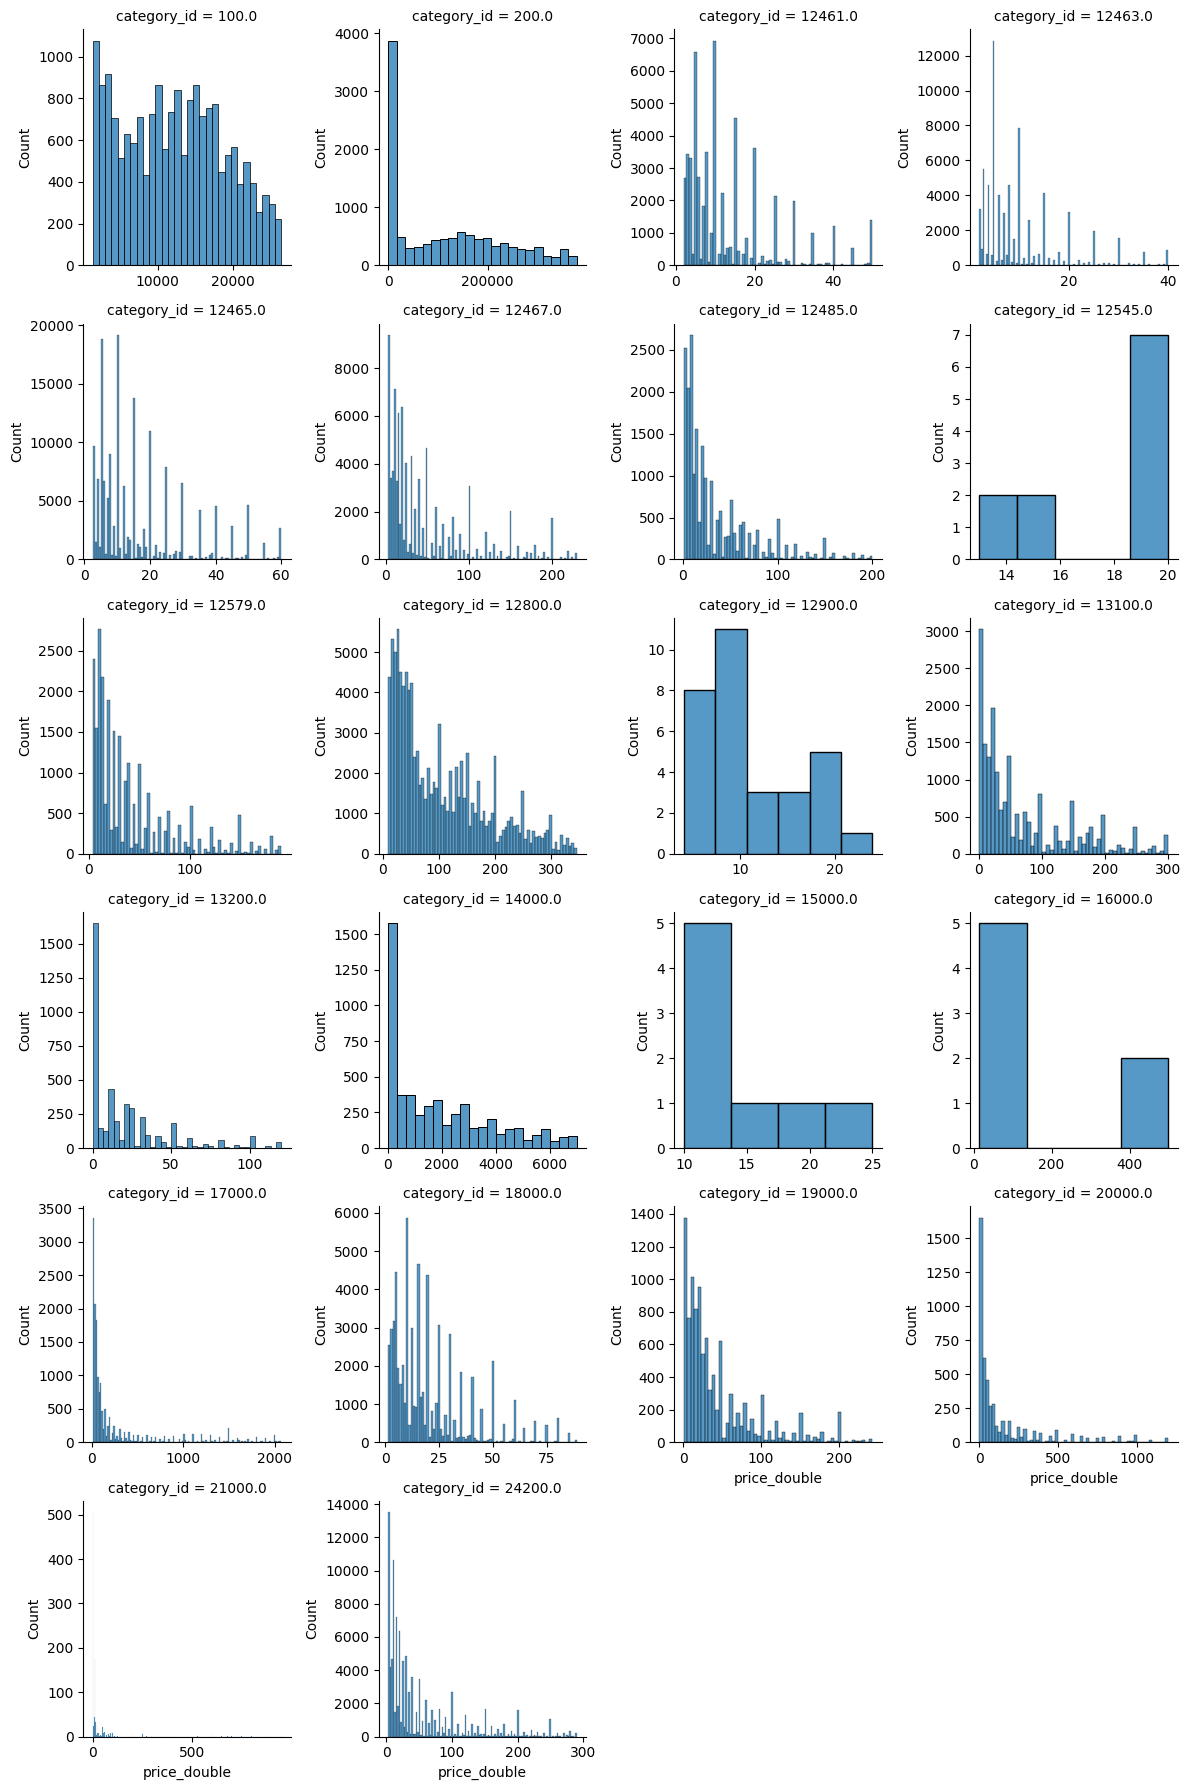

In [59]:
import seaborn as sns

g = sns.FacetGrid(filtered_prices, col="category_id", col_wrap=4, sharex= False, sharey= False)
g.map(sns.histplot, "price_double")

Now, all distributions have become clearly not normal. Indeed, this was expected because **each category contains many products and every product have different distribution** (probably normal).

In [60]:
grouped = filtered_prices.groupby('category_id')['price_double'].describe()
grouped

,count,mean,std,min,25%,50%,75%,max
category_id,,,,,,,,
100.0,18527.0,12149.016024,6787.953330,1300.0,6000.0,12000.0,17455.00,26490.00
200.0,11288.0,116212.307406,112218.333055,200.0,1500.0,99500.0,199000.00,379000.00
12461.0,56674.0,13.485264,11.298891,2.0,5.0,10.0,18.00,50.00
12463.0,71291.0,10.003876,8.069031,2.0,5.0,7.0,12.00,40.00
12465.0,169326.0,16.914007,14.009838,2.5,6.0,12.0,23.00,60.00
12467.0,87718.0,46.895344,51.772018,3.0,10.0,25.0,60.00,230.00
12485.0,20543.0,34.053838,38.713790,1.0,8.0,19.9,49.95,199.99
12545.0,11.0,17.818182,3.092513,13.0,15.0,20.0,20.00,20.00
12579.0,25443.0,41.367869,41.349977,4.0,12.0,25.0,54.00,190.00


#### Wrapping up

Data cleaning still needs a lot of work. One of the key considerations here is that each data point is classified into categories. Each category has multiple and nested hierarchy chains within its taxonomy. A good cleaning algorithm will have to consider how all these variable affect the price of the products. Another important consideration as per the original poster, some people create adds with **symbolic** prices, either to gauge interest without exposing the real value of assets or to have insanely high prices in hopes to **bait** consumers, risking never selling their assets.

## Exploratory Data Analysis

“EDA is an attitude”. This means that we have to find the main characteristics of our dataset rather than following a specific set of techniques.

### Gender distribution

More than 97% of the users do not have a defined gender.

### Geographic Distribution

There's some sort of issue with Athena queries, as it seems to return only a limited set of the data, even after ordering.

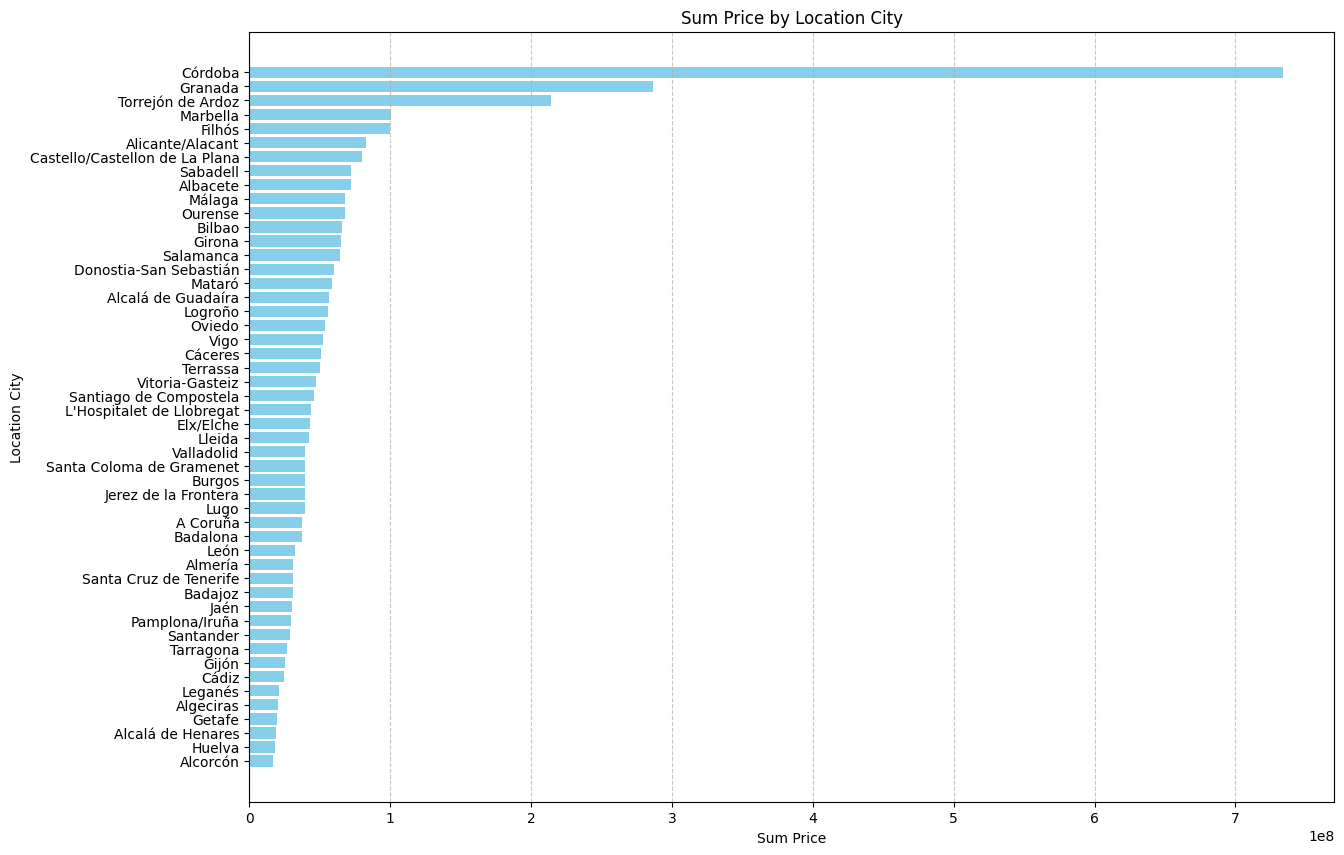

In [61]:
df = pd.read_csv("data/geodata.csv")
df = df.sort_values("sum_price", ascending= False).head(50)

# Plotting
plt.figure(figsize=(14, 10))
plt.barh(df['location_city'], df['sum_price'], color='skyblue')
plt.xlabel('Sum Price')
plt.ylabel('Location City')
plt.title('Sum Price by Location City')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Interesting enough the major metro cities such as Lisbon, Porto, Madrid, Barcelona aren't remotely in the top sellers. This might be explained per the housing adds or non durable goods present which inflate prices.

However, by article count, the results are as expected (more or less).

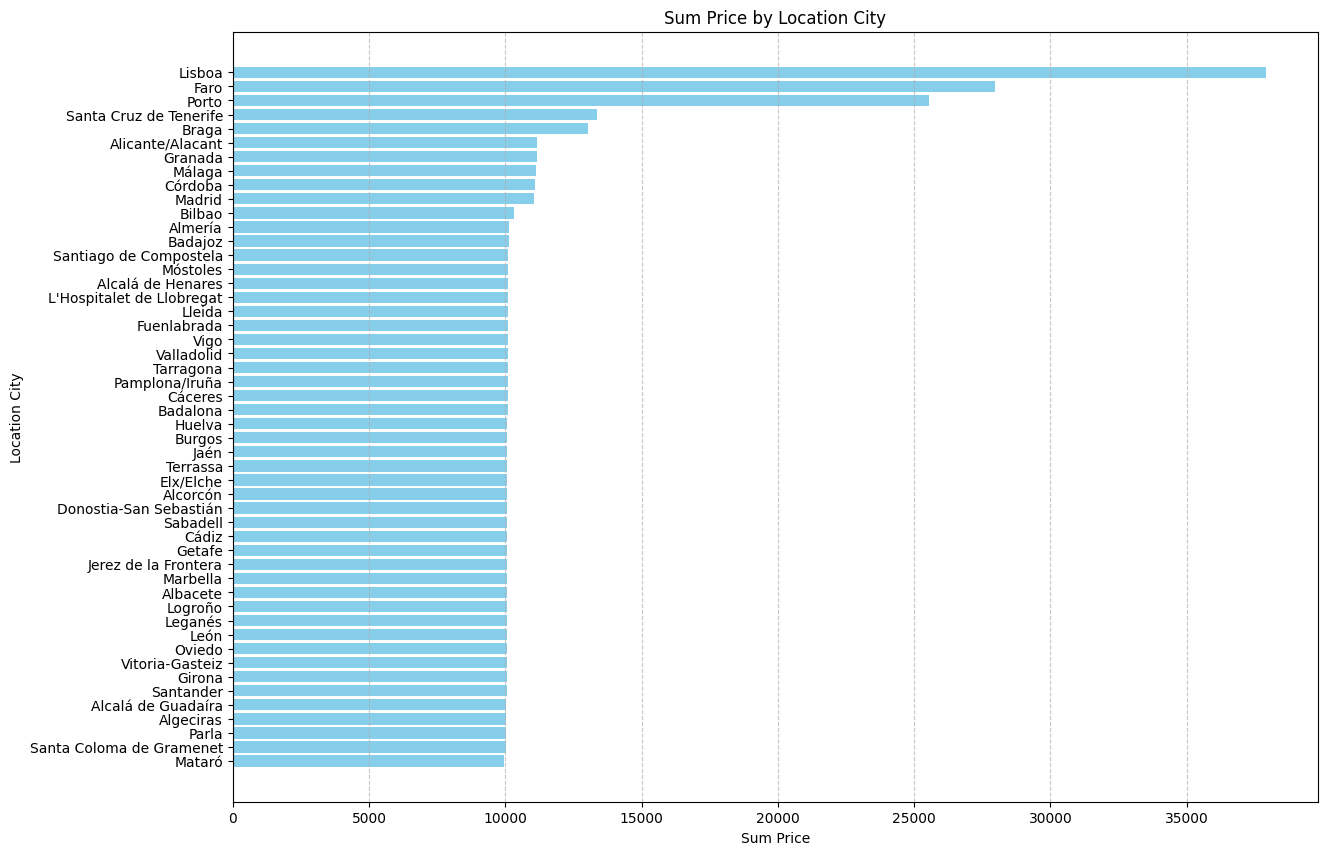

In [62]:
df = pd.read_csv("data/geocounts.csv")
df = df.sort_values("count_articles", ascending= False).head(50)

# Plotting
plt.figure(figsize=(14, 10))
plt.barh(df['location_city'], df['count_articles'], color='skyblue')
plt.xlabel('Sum Price')
plt.ylabel('Location City')
plt.title('Sum Price by Location City')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Turns out the top location cities are Portuguese rather than Spanish.

#### Categories

<Figure size 1600x1200 with 0 Axes>

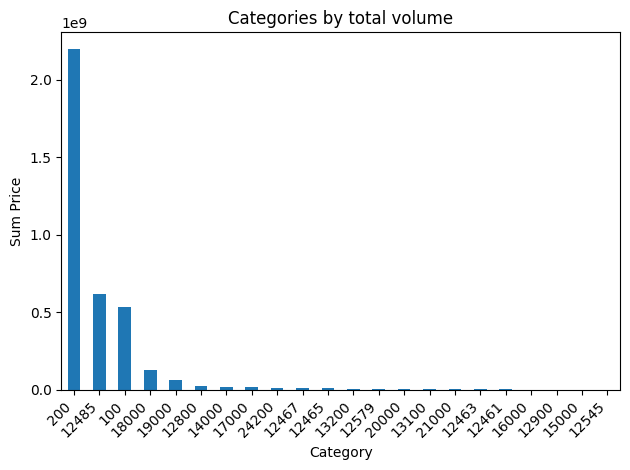

In [63]:
df = pd.read_csv("data/categories.csv")
df = df.sort_values("sum_price", ascending = False)

plt.figure(figsize=(16, 12))
df.plot(kind='bar', x='category_id', y='sum_price', legend=False)
plt.xlabel('Category')
plt.ylabel('Sum Price')
plt.title('Categories by total volume')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#### Number of Cities ranked as the top category by item value

<Figure size 1600x1200 with 0 Axes>

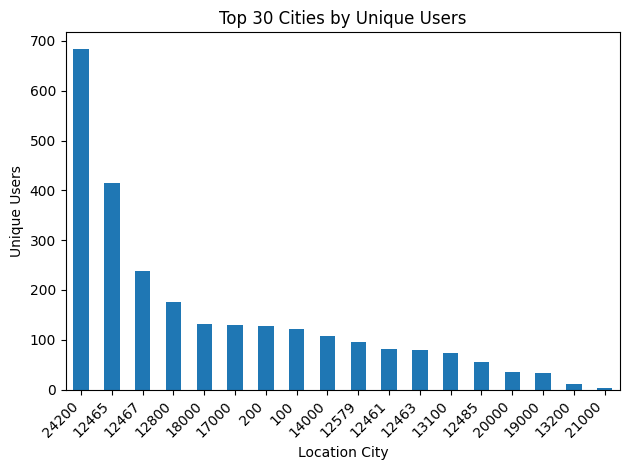

In [64]:
df = pd.read_csv("data/cat_rank.csv")
df = df.sort_values("count_location_city", ascending= False)

plt.figure(figsize=(16, 12))
df.plot(kind='bar', x='category_id', y='count_location_city', legend=False)
plt.xlabel('Location City')
plt.ylabel('Unique Users')
plt.title('Top 30 Cities by Unique Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### Users


<Figure size 1600x1200 with 0 Axes>

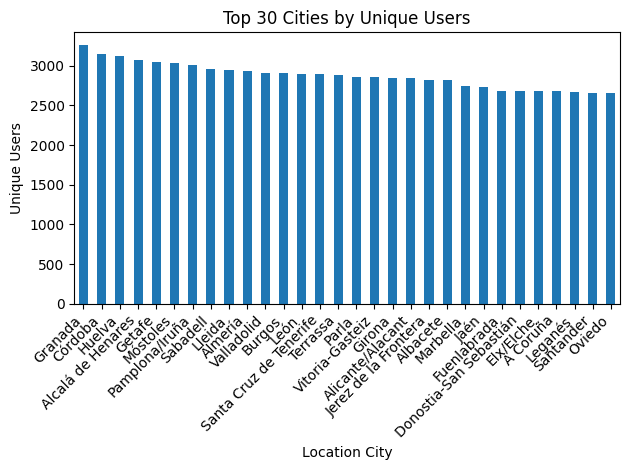

In [65]:
df = pd.read_csv("data/users_region.csv")
df = df.sort_values("unique_users", ascending= False).head(30)


plt.figure(figsize=(16, 12))
df.plot(kind='bar', x='location_city', y='unique_users', legend=False)
plt.xlabel('Location City')
plt.ylabel('Unique Users')
plt.title('Top 30 Cities by Unique Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [86]:
df = pd.read_csv("data/articles_user.csv")
df.describe()

,items
count,172694.000000
mean,4.623594
std,47.366100
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,12710.000000


### Listings creation date per category

C:\Users\Miguel\AppData\Local\Temp\ipykernel_17412\2061570374.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['month'].dt.to_period('M').dt.to_timestamp()


<Figure size 1600x1400 with 0 Axes>

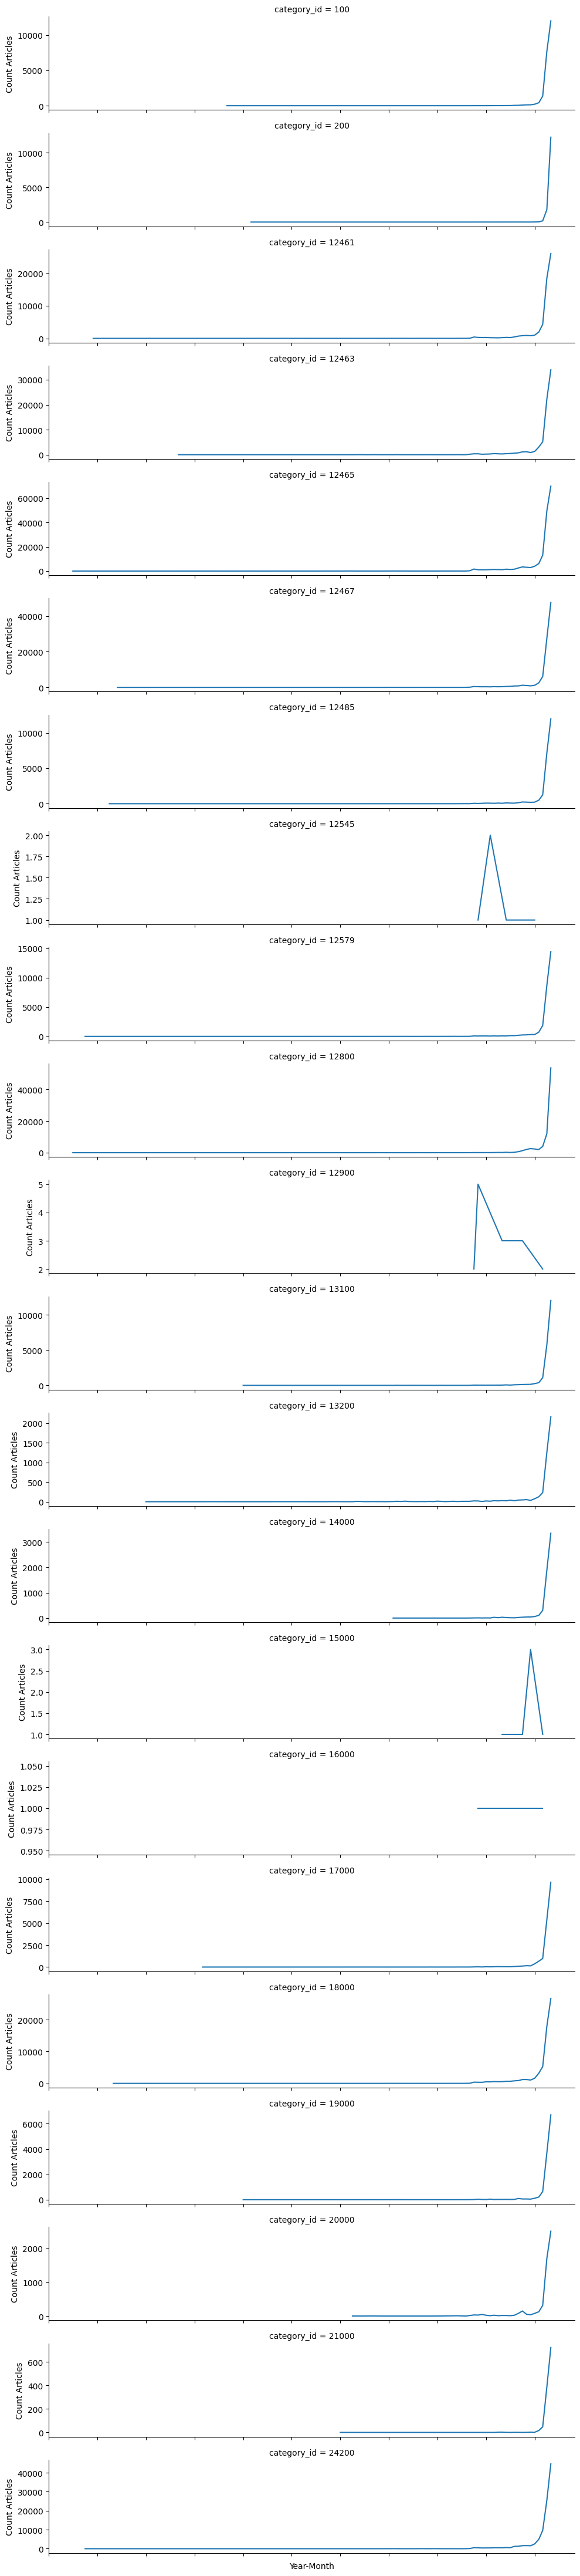

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/timeseries.csv")

df['month'] = pd.to_datetime(df['month'])
df['year_month'] = df['month'].dt.to_period('M').dt.to_timestamp()

grouped_df = df.groupby(['year_month', 'category_id']).agg(
    count_articles=('count_articles', 'size'),
    sum_price=('sum_price', 'sum')
).reset_index()

plt.figure(figsize=(12, 14))

# Initialize the FacetGrid object
g = sns.FacetGrid(grouped_df, row="category_id", height=1, aspect=5, sharex= True, sharey= False)

# Create the plots
g.map_dataframe(sns.lineplot, x="year_month", y="count_articles")

# Set the axis labels and title
g.set_axis_labels("Year-Month", "Count Articles")
g.set_titles(col_template="Category ID: {col_name}")
g.set_xticklabels(rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

#### Average article price per date (rolling average)

Annualized is better to see the actual price tendencies as result of inflation (and other factors).

C:\Users\Miguel\AppData\Local\Temp\ipykernel_17412\3469927281.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['month'].dt.to_period('M').dt.to_timestamp()


<Figure size 1600x1400 with 0 Axes>

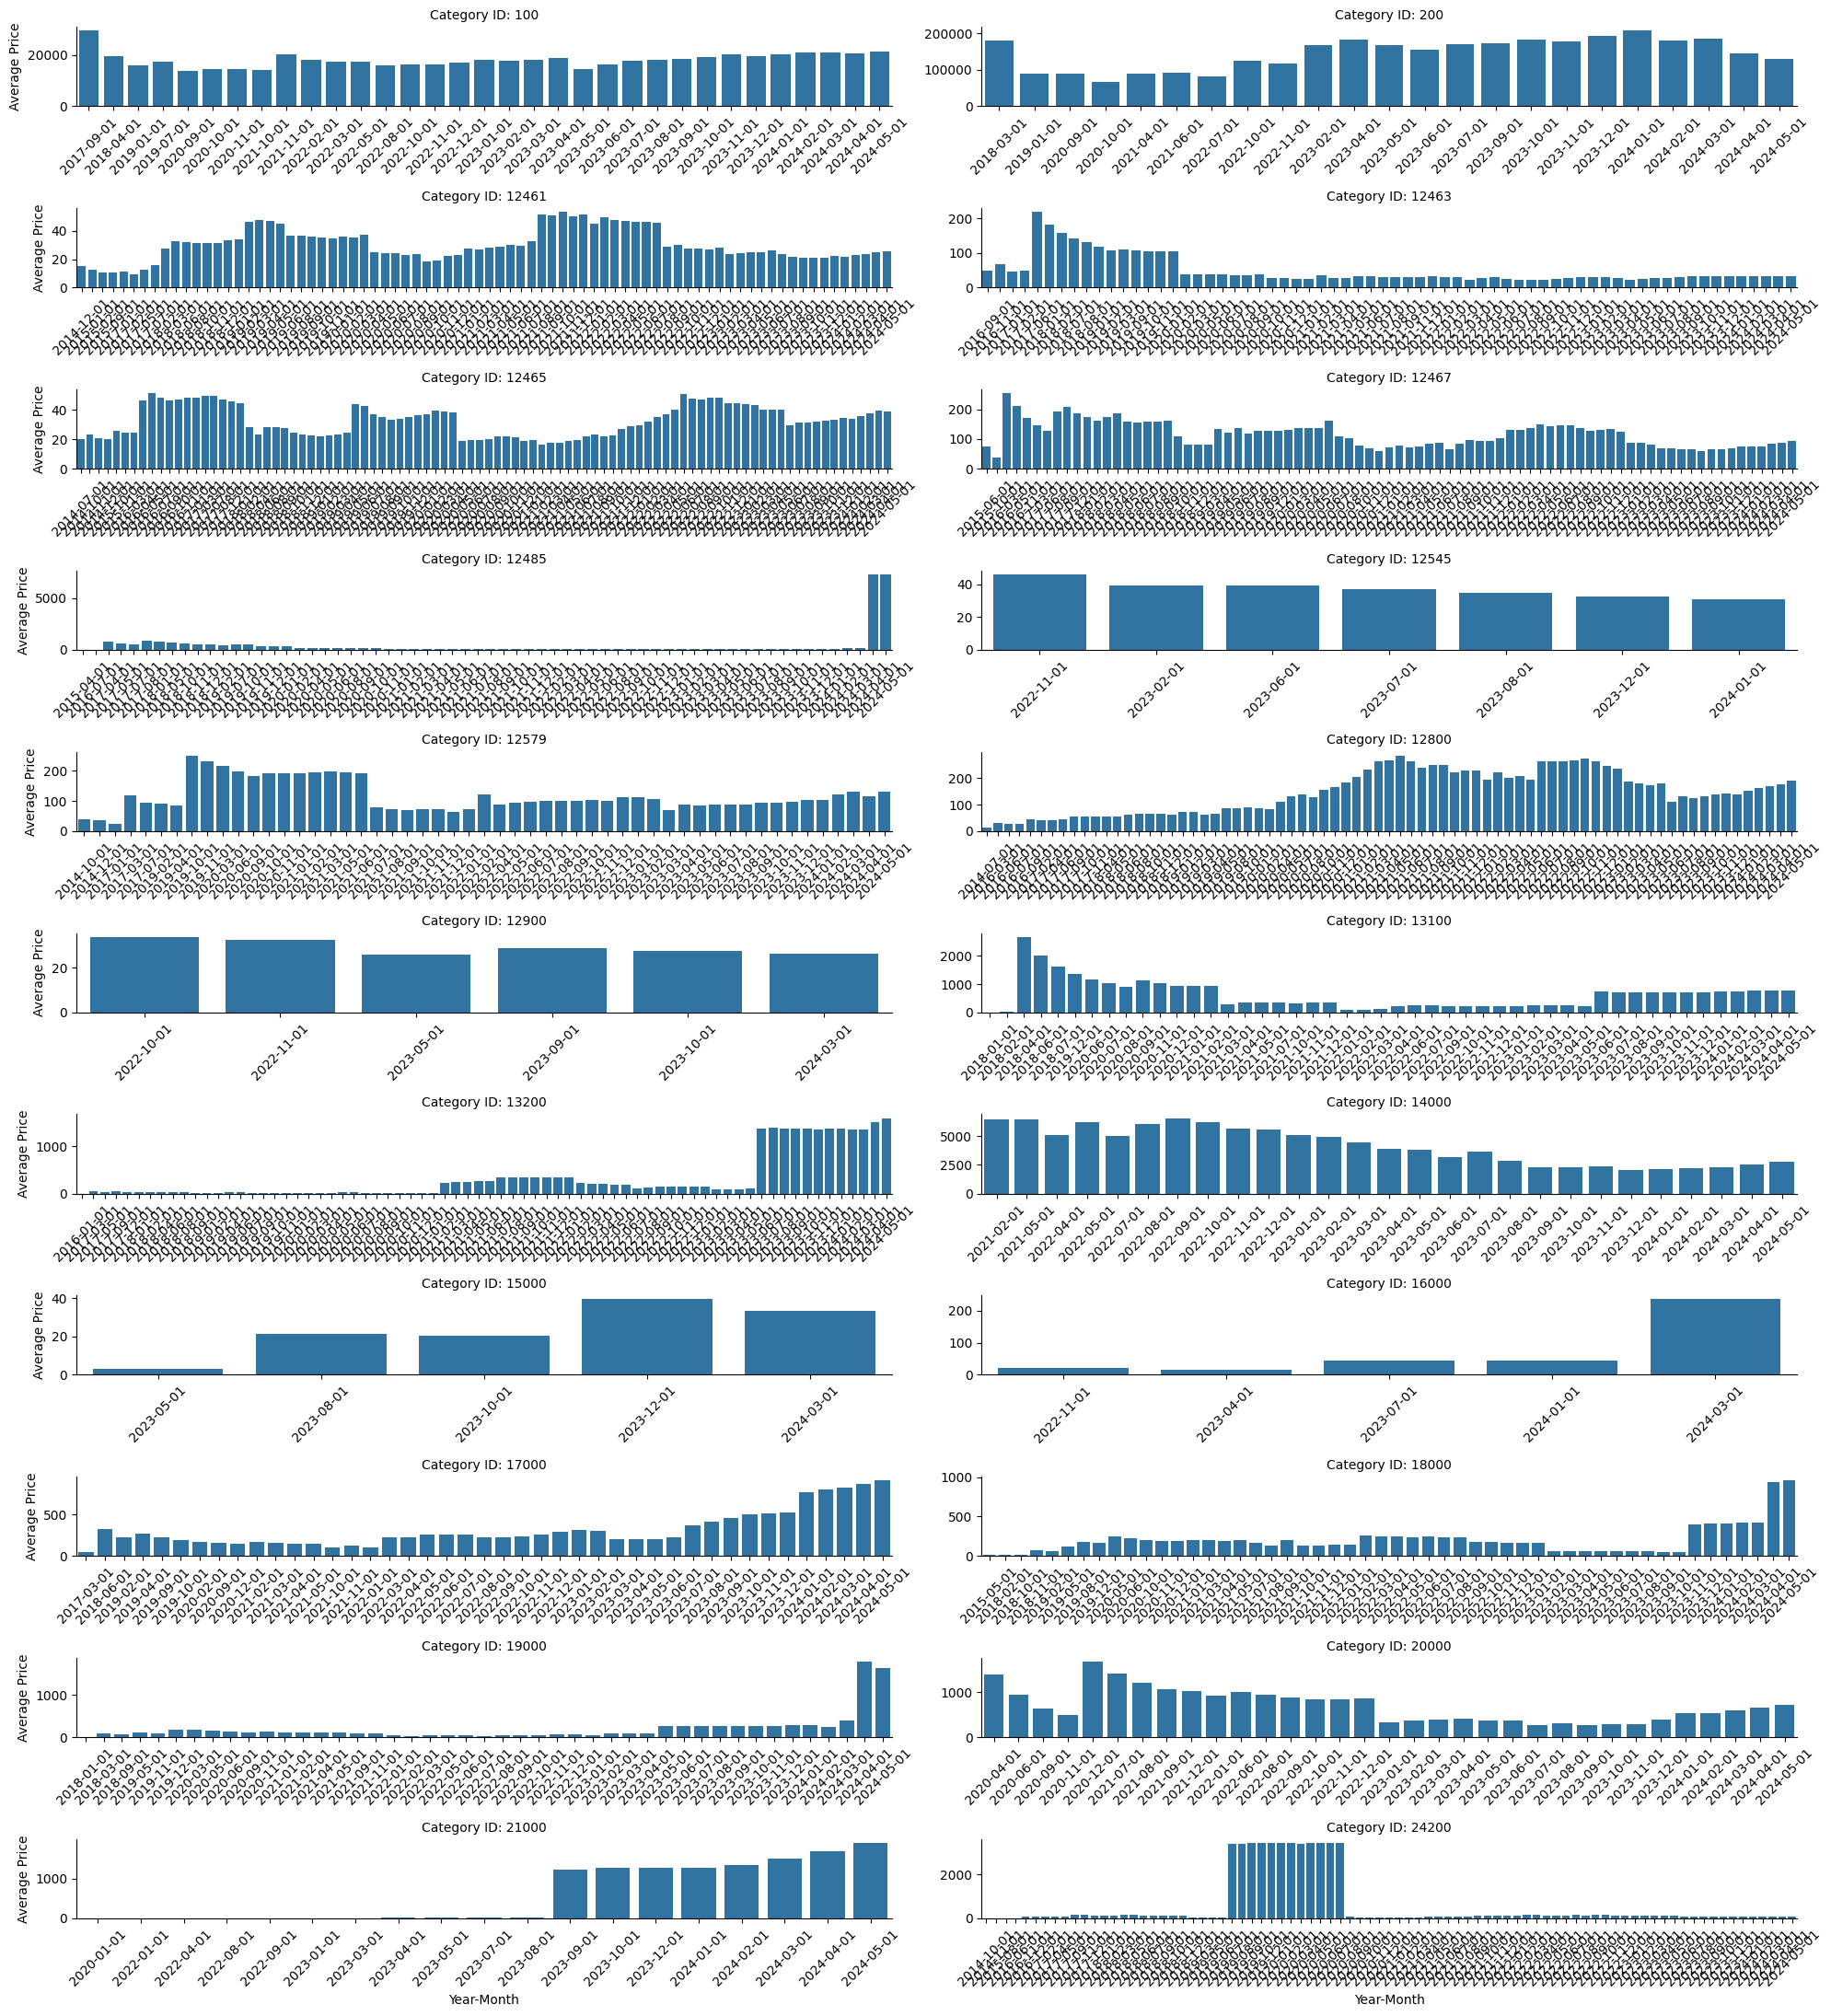

In [98]:
df = pd.read_csv("data/timeseries.csv")
df['month'] = pd.to_datetime(df['month'])
df['year_month'] = df['month'].dt.to_period('M').dt.to_timestamp()

plt.figure(figsize=(16, 14))

grouped_df = df.groupby(['year_month', 'category_id']).agg(
    avg_price=('sum_price', 'mean')
).reset_index()

# Compute the rolling mean of the previous 12 months
grouped_df['avg_price_12mo'] = grouped_df.groupby('category_id')['avg_price'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

# Initialize the FacetGrid object
g = sns.FacetGrid(grouped_df, col="category_id", height=2, aspect=5, sharex= False, sharey= False, col_wrap=2)

# Create the plots
g.map_dataframe(sns.barplot, x="year_month", y="avg_price_12mo")

# Set the axis labels and title
g.set_axis_labels("Year-Month", "Average Price")
g.set_titles(col_template="Category ID: {col_name}")
g.set_xticklabels(rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

#### Sold Products

In [95]:
sold = pd.read_csv("data/sold_category.csv")
sold.describe()

,review_date,item_category_id
count,1.307882e+06,1.307882e+06
mean,1.654132e+12,1.347159e+04
std,6.189001e+10,2.482707e+03
min,1.413403e+12,1.000000e+02
25%,1.628020e+12,1.246500e+04
50%,1.674929e+12,1.248500e+04
75%,1.700408e+12,1.290000e+04
max,1.716230e+12,2.420000e+04


In [ ]:
# Convert creation_date to datetime
sold['review_date'] = pd.to_datetime(sold['review_date'], unit='ms')

# Extract year-month
sold['review_date'] = sold['review_date'].dt.to_period('M').dt.to_timestamp()

# Group by year_month and category_id
grouped_df = sold.groupby(['review_date', 'item_category_id'])["item_id"].count().reset_index()
grouped_df

,review_date,item_category_id,item_id
0,2014-10-01,12461,1
1,2014-10-01,12463,3
2,2014-10-01,12465,22
3,2014-10-01,12467,7
4,2014-10-01,12485,4
...,...,...,...
1962,2024-05-01,18000,4300
1963,2024-05-01,19000,792
1964,2024-05-01,20000,310
1965,2024-05-01,21000,1


<Figure size 1600x1400 with 0 Axes>

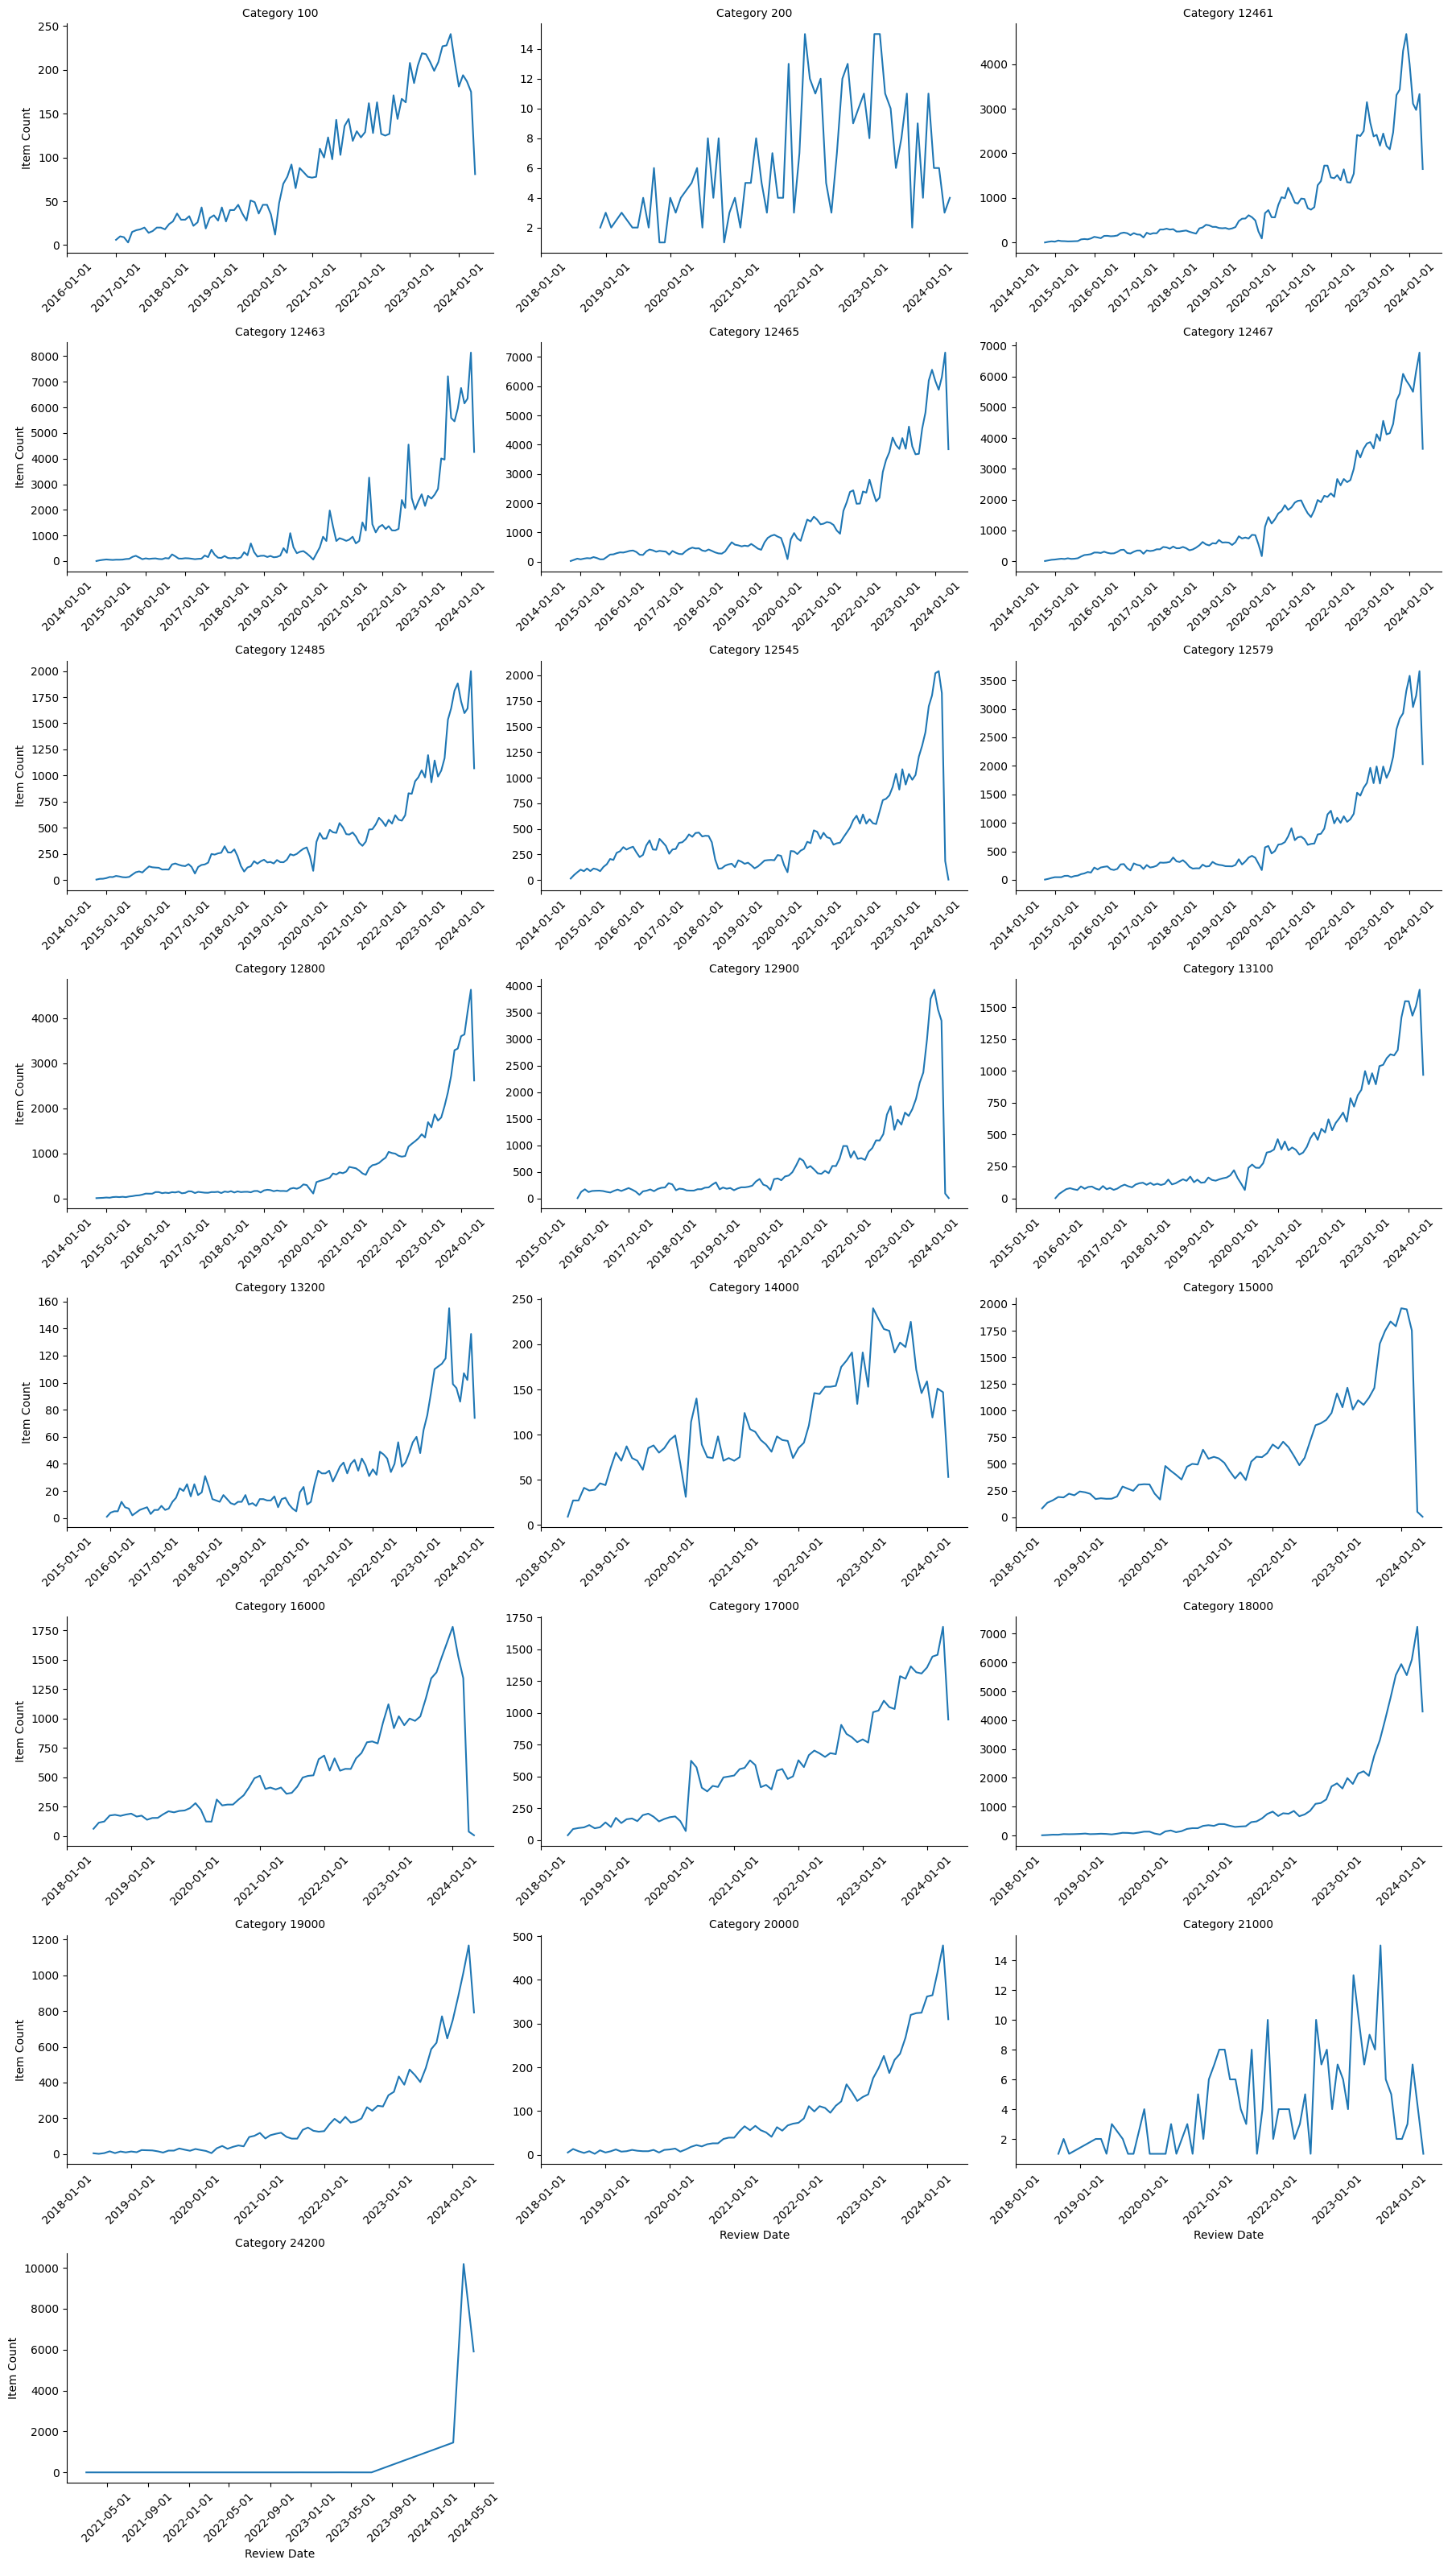

In [ ]:
plt.figure(figsize=(16, 14))

# Plotting
g = sns.FacetGrid(grouped_df, col="item_category_id", col_wrap=3, height=4, aspect=1.5, sharex= False, sharey= False)
g.map(sns.lineplot, 'review_date', 'item_id')

g.set_axis_labels("Review Date", "Item Count")
g.set_titles("Category {col_name}")
g.set_xticklabels(rotation=45)
g.add_legend()

plt.tight_layout()
plt.show()

## Conclusion

To wrap up this post, the key findings presented here tell us what Marketing and Business Analysts have already pointed to which is the rise of second hand marketplaces and changing consumer patterns towards online shopping, specially mobile users.

## Future Work

There's a lot that can be made here depending on what's your use case for this data. For me, I think one of the most valuable ways to analyze this information is to find insights about users spending patterns and trends. I'm going to lay a foundational model on how I would achieve that.
